### Necessary imports

In [1]:
# more advanced grid generation in https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_meshkernel_creategrid.py
# more advanced modelbuilding in https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_modelbuilder.py
import os
import matplotlib.pyplot as plt
plt.close('all')
import dfm_tools as dfmt
from dfm_tools import modelbuilder as mb
import hydrolib.core.dflowfm as hcdfm
import xarray as xr
import pandas as pd
import contextily as ctx
import getpass
from pathlib import Path

c:\Users\aleksand\AppData\Local\mambaforge\envs\dfm_tools_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Settings
Run the settings cell of the model to generate, choose from reunion

In [2]:
model_name = 'mozambique'

#### Mozambique

In [48]:
# Set model name
if model_name == 'mozambique':

    #Set directory for model
    dir_output = Path(r'p:\11210471-001-compass\02_Models\Delft3DFM\mozambique_modelbuilder')
    
    # domain and resolution
    lon_min, lon_max, lat_min, lat_max = 32, 47, -28, -9
    dxy = 0.5                # Basegrid resolution in degrees (0.5 deg is ~50 km)
    bnd_dlon_dlat = 1.0/8.0  # Steps along the boundary in degrees
    
    #Grid settings
    is_geographic = True #Spherical grid
    crs = 'EPSG:4326'
    min_edge_size = 500      # Min cell size after refinement in meters
    
    #Base MDU to get settings from
    base_mdu = Path(r'p:\11210471-001-compass\02_Models\Delft3DFM\mozambique_modelbuilder\GTSM_base_model_settings.mdu')
    
    #path style specifications, windows and path_relative results in a unix & windows compatible model
    path_style = 'windows' # windows / unix
    paths_relative = True
    
    #Wheter or not to overwrite existing meteo download files
    overwrite = False # used for downloading of forcing data. Always set to True when changing the domain
    
    #Re-interpolated boundary forcingmodel
    overwrite_tidal_boundary = False
    
    #dates as understood by pandas.period_range(). ERA5 has freq='M' (month) and CMEMS has freq='D' (day)
    date_min = '2019-03-01' 
    date_max = '2019-03-16'
    ref_date = date_min
    
    # Settings for adding SFINCS observation points
    # Use this for adding observation point from a SFINCS boundary file
    add_sfincs_observations_from_bnd = True
    add_sfincs_observations_from_coastline = False
    
    sfincs_models = {'sofala': {'bnd_file': Path(r'..\..\sfincs_sofala\sfincs_sofala\sfincs.bnd'),
                                 'epsg': 'epsg:32736',
                                 'lon_min_sfincs' : 34.33,
                                 'lon_max_sfincs' : 34.95,
                                 'lat_min_sfincs' : -20.12,
                                 'lat_max_sfincs' : -19.30,
                                 'interval_coastline' : 0.05,
                                 'resolution_coastline': 'i',
                                 'threshold_mindepth' : 5}
                    }


In [4]:
# make dirs and list all files
os.makedirs(dir_output, exist_ok=True)
dir_output_data = os.path.join(dir_output, 'data')
os.makedirs(dir_output_data, exist_ok=True)
dir_output_sfincs = os.path.join(dir_output, 'sfincs')
os.makedirs(dir_output_sfincs, exist_ok=True)
os.listdir(dir_output)

['data', 'GTSM_base_model_settings.mdu', 'sfincs']

## Grid generation and refinement with meshkernelpy

Notebook with more details exposed: https://github.com/Deltares/MeshKernelPy/blob/main/docs/examples/06_mesh2d_refinement_gridded_samples_gebco.ipynb

In [49]:
#generate spherical regular grid
mk_object = dfmt.make_basegrid(lon_min, lon_max, lat_min, lat_max, dx=dxy, dy=dxy, crs=crs)
print('Basegrid created')

# generate plifile from grid extent and coastlines
bnd_gdf = dfmt.generate_bndpli_cutland(mk=mk_object, res='h', buffer=0.01)
bnd_gdf['name'] = f'{model_name}_bnd'
bnd_gdf_interp = dfmt.interpolate_bndpli(bnd_gdf,res=bnd_dlon_dlat)

Basegrid created
>> reading coastlines: 2.89 sec
attemting to merge lines in MultiLineString to single LineString (if connected)


In [51]:
#   TEMPORARY FIX - CHECK WHY ALL POLYLINES HAVE SAME NAME (CAUSES ERROR)
bnd_gdf_interp.loc[0,'name'] = 'mozambique_bnd0'
bnd_gdf_interp.loc[1,'name'] = 'mozambique_bnd1'
bnd_gdf_interp.loc[2,'name'] = 'mozambique_bnd2'
bnd_gdf_interp.loc[3,'name'] = 'mozambique_bnd3'
bnd_gdf_interp

,geometry,name
0,"LINESTRING (47.00000 -25.05213, 47.00000 -25.1...",mozambique_bnd0
1,"LINESTRING (39.34706 -8.55386, 39.47206 -8.55386)",mozambique_bnd1
2,"LINESTRING (39.57464 -8.55386, 39.69964 -8.553...",mozambique_bnd2
3,"LINESTRING (47.00000 -15.44449, 47.00000 -15.4...",mozambique_bnd3


Boundary polygon created
>> reading coastlines: 2.47 sec


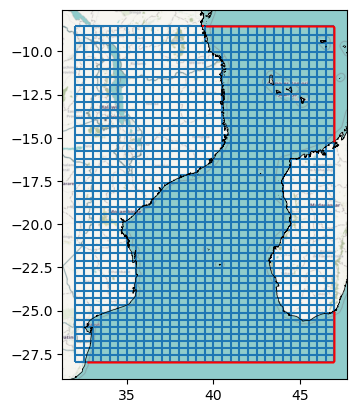

In [52]:
# create grid
poly_file = os.path.join(dir_output, f'{model_name}.pli')
pli_polyfile = dfmt.geodataframe_to_PolyFile(bnd_gdf_interp)
pli_polyfile.save(poly_file)
print('Boundary polygon created')

#plot basegrid and polyline
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
bnd_gdf_interp.plot(ax=ax, edgecolor='r')
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


In [53]:
# refine grid

# use GEBCO bathymetry
file_gebco = Path(r'p:\metocean-data\open\GEBCO\2021\GEBCO_2021.nc')
data_bathy_sel = xr.open_mfdataset(file_gebco)

#Only select the relevant part of bathymetry from GEBCO
data_bathy_sel = data_bathy_sel.sel(lon=slice(lon_min-1, lon_max+1), lat=slice(lat_min-1, lat_max+1))

#refine
dfmt.refine_basegrid(mk=mk_object, data_bathy_sel=data_bathy_sel['elevation'], min_edge_size=min_edge_size)

#plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


In [ ]:
# remove land with GSHHS coastlines
dfmt.meshkernel_delete_withcoastlines(mk=mk_object, res='h')

#plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


In [ ]:
#convert to xugrid, interpolate z-values and write to netcdf
xu_grid_uds = dfmt.meshkernel_to_UgridDataset(mk=mk_object, crs=crs)

#interp bathy
data_bathy_interp = data_bathy_sel.interp(lon=xu_grid_uds.obj.mesh2d_node_x, lat=xu_grid_uds.obj.mesh2d_node_y).reset_coords(['lat','lon'])
xu_grid_uds['mesh2d_node_z'] = data_bathy_interp.elevation.clip(max=10)

#plot bathy and grid
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.mesh2d_node_z.ugrid.plot(ax=ax,center=False)
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='white',alpha=0.2)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)

#write xugrid grid to netcdf
netfile  = os.path.join(dir_output, f'{model_name}_net.nc')
xu_grid_uds.ugrid.to_netcdf(netfile)


## Generate boundary conditions from GTSMv4.1

In [ ]:
# new ext: initial and open boundary condition
bc_filename = os.path.join(dir_output, f'{model_name}_tidal_boundary.bc')
ext_file_new = os.path.join(dir_output, f'{model_name}_new.ext')

ext_new = hcdfm.ExtModel()
if (not overwrite_tidal_boundary) and os.path.exists(bc_filename): #Create new tidal boundary
    #Load it from file
    ForcingModel = hcdfm.ForcingModel(bc_filename)
else: #Create new tidal boundary
    ForcingModel = dfmt.interpolate_tide_to_bc('GTSMv4.1', poly_file)
    ForcingModel.save(filepath=bc_filename,path_style=path_style)

#add boundary to new ext file
boundary_object = hcdfm.Boundary(quantity='waterlevelbnd', #the FM quantity for tide is also waterlevelbnd
                                 locationfile=poly_file,
                                 forcingfile=ForcingModel)
ext_new.boundary.append(boundary_object)

#Save new ext forcing file
ext_new.save(filepath=ext_file_new,path_style=path_style)


## Generate ERA5 meteo forcing (old ext)

In [ ]:
# old ext

# CMEMS - initial condition file
ext_file_old = os.path.join(dir_output, f'{model_name}_old.ext')
ext_old = hcdfm.ExtOldModel()

# ERA5 - download
dir_output_data_era5 = os.path.join(dir_output_data,'ERA5')
os.makedirs(dir_output_data_era5, exist_ok=True)
    
varlist_list = [['msl','u10n','v10n','chnk']]

for varlist in varlist_list:
    for varkey in varlist:
        dfmt.download_ERA5(varkey, 
                           longitude_min=lon_min-1, longitude_max=lon_max+1, latitude_min=lat_min-1, latitude_max=lat_max+2,
                           date_min=date_min, date_max=date_max,
                           dir_output=dir_output_data_era5, overwrite=overwrite)

# ERA5 meteo - convert to netCDF for usage in Delft3D FM
ext_old = mb.preprocess_merge_meteofiles_era5(ext_old=ext_old,
                                              varkey_list = varlist_list,
                                              dir_data = dir_output_data_era5,
                                              dir_output = dir_output,
                                              time_slice = slice(date_min, date_max))

ext_old.save(filepath=ext_file_old,path_style=path_style)


In [ ]:
# plot ERA5 data example
file_era5 = os.path.join(dir_output,'data','ERA5','*.nc')
ds_era5 = xr.open_mfdataset(file_era5)
ds_era5

#plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ds_era5.u10n.isel(time=0).plot(ax=ax1)
dfmt.plot_coastlines(ax=ax1, crs=crs)
ds_era5.v10n.isel(time=0).plot(ax=ax2)
dfmt.plot_coastlines(ax=ax2, crs=crs, res= 'l')
fig.tight_layout()


## Generate observation points

##### Load GTSM observation points, filter points in domain and write .obs file

In [ ]:
#Initialiase empty list for observation XYNmodels
obs_list = [] 

In [ ]:
# Load GTSM observation points
obs_GTSM = hcdfm.XYNModel(r'p:\11208614-de-370a\00_general_data\DFLOWFM\GTSM_reference_timeseries\available_stations_obs.xyn')

#Filter obs_GTSM_df to only select point within lon_min, lon_max, lat_min and lat_max
from shapely import geometry
bounding_box = geometry.Polygon([(lon_min, lat_min),
                                (lon_min, lat_max),
                                (lon_max, lat_max),
                                (lon_max, lat_min)])

obspoints = [point for point in obs_GTSM.points \
    if bounding_box.contains(geometry.Point(point.x, point.y))]

obs_GTSM = hcdfm.XYNModel(points = obspoints)
obs_GTSM.save(dir_output / f'{model_name}_GTSM_obs.xyn')
obs_list.append(obs_GTSM)

##### Add points for SFINCS coupling to model

In [ ]:
if add_sfincs_observations_from_bnd:
    from Coupling_SFINCS_DFLOWFM import generate_delft3d_obsfile_from_sinfcs_bnd
    for sfincs_model, sfincs_model_info in sfincs_models.items():
        obsfile_output = dir_output / f'{sfincs_model}_SFINCS_obs.xyn'
        obsfile_output_crs = 'epsg:4326'

        generate_delft3d_obsfile_from_sinfcs_bnd(sfincs_model_info['bnd_file'],
                                                sfincs_model_info['epsg'],
                                                obsfile_output,
                                                obsfile_output_crs)

        obs_SFINCS = hcdfm.XYNModel(obsfile_output)
        obs_list.append(obs_SFINCS)

In [ ]:
if add_sfincs_observations_from_coastline:
    if model_name=='st_maarten':
        netfile = dir_output / f'{model_name}_map.nc'
    from Coupling_SFINCS_DFLOWFM import generate_coastline_obspoints
    for sfincs_model, sfincs_model_info in sfincs_models.items():
        obsfile_output = dir_output / f'{sfincs_model}_SFINCS_obs.xyn'
        generate_coastline_obspoints(lon_min = sfincs_model_info['lon_min_sfincs'], # degrees
                                    lon_max = sfincs_model_info['lon_max_sfincs'], # degrees
                                    lat_min = sfincs_model_info['lat_min_sfincs'], # degrees
                                    lat_max = sfincs_model_info['lat_max_sfincs'], # degrees
                                    interval = sfincs_model_info['interval_coastline'], # degrees
                                    resolution = sfincs_model_info['resolution_coastline'], # dfm_tools coastline resolution
                                    threshold_mindepth = sfincs_model_info['threshold_mindepth'], # meters
                                    file_nc = netfile, # path to netcdf file
                                    output_file = obsfile_output)
        obs_SFINCS = hcdfm.XYNModel(obsfile_output)
        obs_list.append(obs_SFINCS)


In [ ]:
if add_sfincs_observations_from_coastline:
    from Coupling_SFINCS_DFLOWFM import generate_sfincs_bnd_from_delft3d_xyn
    for sfincs_model, sfincs_model_info in sfincs_models.items():
        generate_sfincs_bnd_from_delft3d_xyn(obs_file_input = dir_output / f'{sfincs_model}_SFINCS_obs.xyn',
                                            obs_file_input_crs = crs,
                                            bnd_file_output = Path(dir_output_sfincs) / f'{sfincs_model}.bnd',
                                            bnd_file_output_crs = sfincs_model_info['epsg'])

## Generate mdu file

In [ ]:
mdu = hcdfm.FMModel(base_mdu)

mdu.geometry.netfile.filepath = Path(dir_output / f'{model_name}_net.nc')

# mdu.external_forcing.extforcefile = ext_old
mdu.external_forcing.extforcefilenew = ext_new 

mdu.time.refdate = pd.Timestamp(ref_date).strftime('%Y%m%d')
mdu.time.tunit = 'S'
mdu.time.dtmax = 120
mdu.time.startdatetime = pd.Timestamp(date_min).strftime('%Y%m%d%H%M%S')
mdu.time.stopdatetime = pd.Timestamp(date_max).strftime('%Y%m%d%H%M%S')
mdu.time.autotimestep = 1

mdu.output.obsfile = obs_list
mdu.output.hisinterval = [600]
mdu.output.mapinterval = [3600] #[86400]
mdu.output.rstinterval = [0] #TODO: default is 0.0, but this translates to [0.0 tstart tstop] instead of [0]: https://github.com/Deltares/HYDROLIB-core/issues/525#issuecomment-1505111924
mdu.output.statsinterval = [3600]

mdu_file = dir_output / f'{model_name}.mdu'
mdu.save(mdu_file,path_style=path_style)

In [ ]:
#Temporary fix to make all filepaths relative to the basefolder of the model, 
if paths_relative:
    for filename in [mdu_file,ext_file_new]:   # ,ext_file_old
        with open(filename, 'r') as file :
            filedata = file.read()
        filedata = filedata.replace(str(dir_output).replace('\\','/')+'/', '') #dir_output or os.path.dirname(mdu_file)
        with open(filename, 'w') as file:
            file.write(filedata)


## Check written files in model directory

In [ ]:
os.listdir(dir_output)